# Tutorial: fitting a BL Lac broad-band SED using angpy and sherpa

In order to perform a fit of the broad-band SED of a jetted AGN, `agnpy` includes a `sherpa` wrapper.
The wrapper defines a custom [model.RegriddableModel1D](https://sherpa.readthedocs.io/en/latest/model_classes/api/sherpa.models.model.RegriddableModel1D.html), representing the emission due to a combination of radiative processes. The model can be used to fit flux points.

Several combination of radiative processes can be considered to model the broad-band emission of jetted AGN. For simplicity, we provide wrappers for the two scenarios most-commonly considered:

 * `SycnhrotronSelfComptonModel`, representing the sum of synchrotron and synchrotron self-Compton (SSC) radiation. This scenario is commonly considered to model BL Lac sources;
 
 * `ExternalComptonModel`, representing the sum of synchrotron and synchrotron self-Compton radiation along with an external Compton (EC) component. EC scattering can be computed considering a list of target photon fields. This scenario is commonly considered to model flat spectrum radio quasars (FSRQs).

In this tutorial, we will show how to use the `SynchrotronSelfComptonModel` to fit the broad-band SED of Mrk 421, measured by a MWL campaign in 2009 [(Abdo et al. 2011)](https://ui.adsabs.harvard.edu/abs/2011ApJ...736..131A/abstract).

[sherpa](https://sherpa.readthedocs.io/en/latest/index.html) is required to run this notebook.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import pkg_resources

# import agnpy classes
from agnpy.spectra import BrokenPowerLaw
from agnpy.fit import SynchrotronSelfComptonModel, load_sherpa_flux_points
from agnpy.utils.plot import load_mpl_rc, sed_y_label

load_mpl_rc()

# import sherpa classes
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar

### `sherpa` wrapper of `agnpy`


The `SynchrotronSelfComptonModel` wraps the `agnpy` functions to compute synchrotron and SSC radiation and returns a `model.RegriddableModel1D`. To initialise the model, only the electron distribution has to be specified, the remaining parameters (the ones of the emission region) will be initialised automatically and can be modified at a later stage.

The `SynchrotronSelfComptonModel` class provides both the `sherpa` and `gammapy` wrappers. You should specify, through the `backend` argument, which package you want to use.

In [2]:
# electron energy distribution
n_e = BrokenPowerLaw(
    k_e=1e-8 * u.Unit("cm-3"),
    p1=2.02,
    p2=3.43,
    gamma_b=1e5,
    gamma_min=500,
    gamma_max=1e6,
)

# initialise the sherpa model
ssc_model = SynchrotronSelfComptonModel(n_e, backend="sherpa")

Let us set appropriate parameters for the emission region. The size of the blob, $R_{\rm b}$, is set by the variability timescale, $t_{\rm var}$, via

\begin{equation}
R_{\rm b} = \frac{c \delta_{\rm D} t_{\rm var}}{1 + z},
\end{equation}

where $c$ is the speed of light, $\delta_{\rm D}$ the Doppler factor, and $z$ the redshift.

In [3]:
ssc_model.z = 0.0308
ssc_model.delta_D = 18
ssc_model.t_var = (1 * u.d).to_value("s")
ssc_model.t_var.freeze()
ssc_model.log10_B = -1.3

In [4]:
ssc_model

<SynchrotronSelfComptonRegriddableModel1D model instance 'ssc'>

### Fitting with `sherpa`
Here we start the procedure to fit with `sherpa`.

#### 1) load the MWL flux points, add systematics
A function is provided in `agnpy.fit` to directly load flux points in a `sherpa.data.Data1D` object. It reads the data from a file, included in the package, containing a MWL SED following [these specifications](https://gamma-astro-data-formats.readthedocs.io/en/v0.2/spectra/flux_points/index.html).

The same function allows to add a systematic error on the flux points. This can be done with a dictionary specifying the instrument name and the systematic error, expressed as a relative error on the flux. The systematic error in summed in quadrature to the statistical error.

In this example, we use a very rough and conservative estimate of the systematic errors ($30\%$ of the flux for VHE instruments, $10\%$ for HE and X-ray instruments, $5\%$ for all the other instruments).

Specifying the systematic errors through the dictionary is optional.

We can also set the minimum and maximum energy to be used in the fit. We exclude points below $10^{11}\,{\rm Hz}$, as they are measured in the radio band with large integration regions. They hence include the extended emission of the jet, while in our model we are considering the emission from a finite region of the jet, the blob.

In [5]:
sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/Mrk421_2011.ecsv")

systematics_dict = {
    "Fermi": 0.10,
    "GASP": 0.05,
    "GRT": 0.05,
    "MAGIC": 0.30,
    "MITSuME": 0.05,
    "Medicina": 0.05,
    "Metsahovi": 0.05,
    "NewMexicoSkies": 0.05,
    "Noto": 0.05,
    "OAGH": 0.05,
    "OVRO": 0.05,
    "RATAN": 0.05,
    "ROVOR": 0.05,
    "RXTE/PCA": 0.10,
    "SMA": 0.05,
    "Swift/BAT": 0.10,
    "Swift/UVOT": 0.05,
    "Swift/XRT": 0.10,
    "VLBA(BK150)": 0.05,
    "VLBA(BP143)": 0.05,
    "VLBA(MOJAVE)": 0.05,
    "VLBA_core(BP143)": 0.05,
    "VLBA_core(MOJAVE)": 0.05,
    "WIRO": 0.05,
}

# define minimum and maximum energy to be used in the fit
E_min = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())
E_max = 100 * u.TeV

sed = load_sherpa_flux_points(sed_path, E_min, E_max, systematics_dict)

Let us take a look at the initial model and at the data.

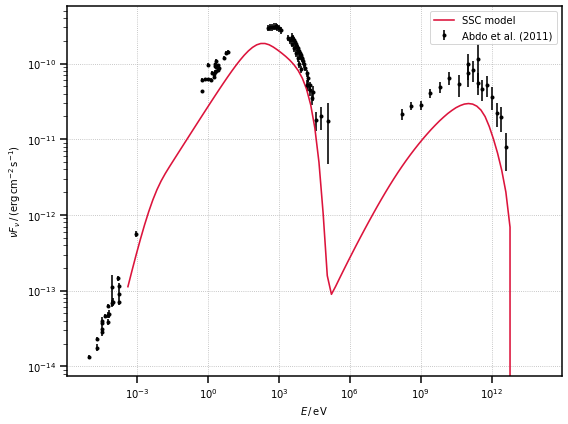

In [6]:
# array of energies to plot the model
E = np.logspace(np.log10(E_min.to_value("eV")), np.log10(E_max.to_value("eV")), 100)

fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(
    sed.x,
    sed.y,
    yerr=sed.get_error(),
    marker=".",
    ls="",
    color="k",
    label="Abdo et al. (2011)",
)
ax.loglog(E, ssc_model(E), ls="-", color="crimson", label="SSC model")
ax.set_ylabel(sed_y_label)
ax.set_xlabel(r"$E\,/\,{\rm eV}$")
ax.legend()

plt.show()

#### 2) run the fit
Now we define the `Fit` procedure choosing the statistics ($\chi^2$) and the optimiser (Levenberg-Marquardt).

In [7]:
fitter = Fit(sed, ssc_model, stat=Chi2(), method=LevMar())

In [8]:
%%time
# perform the fit and time it!
results = fitter.fit()
print("Fit succesful = ", results.succeeded)
print(results.format())

Fit succesful =  True
Method                = levmar
Statistic             = chi2
Initial fit statistic = 3533.13
Final fit statistic   = 270.786 at function evaluation 71
Data points           = 86
Degrees of freedom    = 80
Probability [Q-value] = 1.47258e-22
Reduced statistic     = 3.38482
Change in statistic   = 3262.35
   ssc.log10_k_e   -7.88461     +/- 0.0702959   
   ssc.p1         2.05281      +/- 0.0231709   
   ssc.p2         3.53711      +/- 0.0517896   
   ssc.log10_gamma_b   4.99003      +/- 0.0228676   
   ssc.delta_D    19.809       +/- 0.612714    
   ssc.log10_B    -1.33284     +/- 0.0389128   
CPU times: user 18.6 s, sys: 6.84 s, total: 25.4 s
Wall time: 25.7 s


Plot the final model.

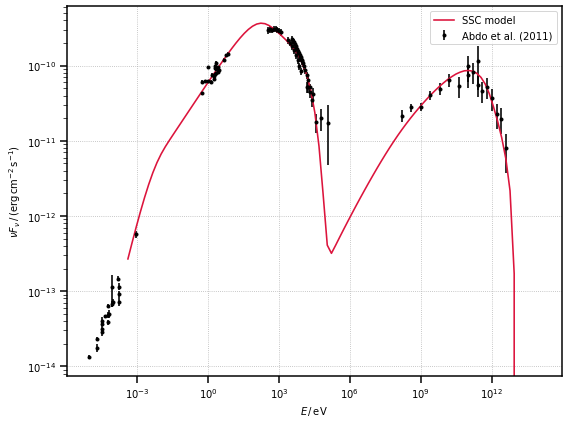

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(
    sed.x,
    sed.y,
    yerr=sed.get_error(),
    marker=".",
    ls="",
    color="k",
    label="Abdo et al. (2011)",
)
ax.loglog(E, ssc_model(E), ls="-", color="crimson", label="SSC model")
ax.set_ylabel(sed_y_label)
ax.set_xlabel(r"$E\,/\,{\rm eV}$")
ax.legend()

plt.show()